Reference: https://www.kaggle.com/gaborvecsei/plants-t-sne

In [1]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import numpy as np
from glob import glob
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [4]:
# BASE_DATA_FOLDER = "C:/Users/Sumi/Desktop/NOTES SEM2/Computer Vision/CV Project/VOCdevkit/VOC2009/JPEGImages/"
BASE_DATA_FOLDER = "C:/Users/Sumi/Desktop/NOTES SEM2/Computer Vision/CV Project/"
TRAin_DATA_FOLDER = BASE_DATA_FOLDER


In [6]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

In [7]:
def visualize_scatter_with_images(X_2d_data, images, figsize=(45,45), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()
def visualize_scatter(data_2d, label_ids, figsize=(20,20)):
    plt.figure(figsize=figsize)
    plt.grid()
    
    nb_classes = len(np.unique(label_ids))
    
    for label_id in np.unique(label_ids):
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',
                    color= plt.cm.Set1(label_id / float(nb_classes)),
                    linewidth='1',
                    alpha=0.8,
                    label=id_to_label_dict[label_id])
    plt.legend(loc='best')

In [14]:
images = []
labels = []

for class_folder_name in os.listdir(TRAin_DATA_FOLDER):
    class_folder_path = os.path.join(TRAin_DATA_FOLDER, class_folder_name)
    for image_path in glob(class_folder_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (150, 150))
        image = segment_plant(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))
        
        image = image.flatten()
        
        images.append(image)
        labels.append(class_folder_name)
        

In [21]:
images = np.array(images)
labels = np.array(labels)
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}
label_ids = np.array([label_to_id_dict[x] for x in labels])
images_scaled = StandardScaler().fit_transform(images)


In [22]:
images_scaled.shape


(7818, 2025)

In [23]:
label_ids.shape


(7818,)

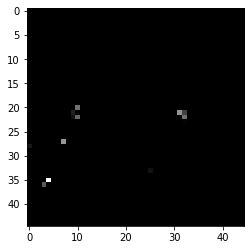

In [26]:
plt.imshow(np.reshape(images[10], (45,45)), cmap="gray")


In [27]:
pca = PCA(n_components=180)
pca_result = pca.fit_transform(images_scaled)
pca_result.shape


(7818, 180)

In [28]:
tsne = TSNE(n_components=2, perplexity=40.0)


In [29]:
tsne_result = tsne.fit_transform(pca_result)


In [30]:
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)


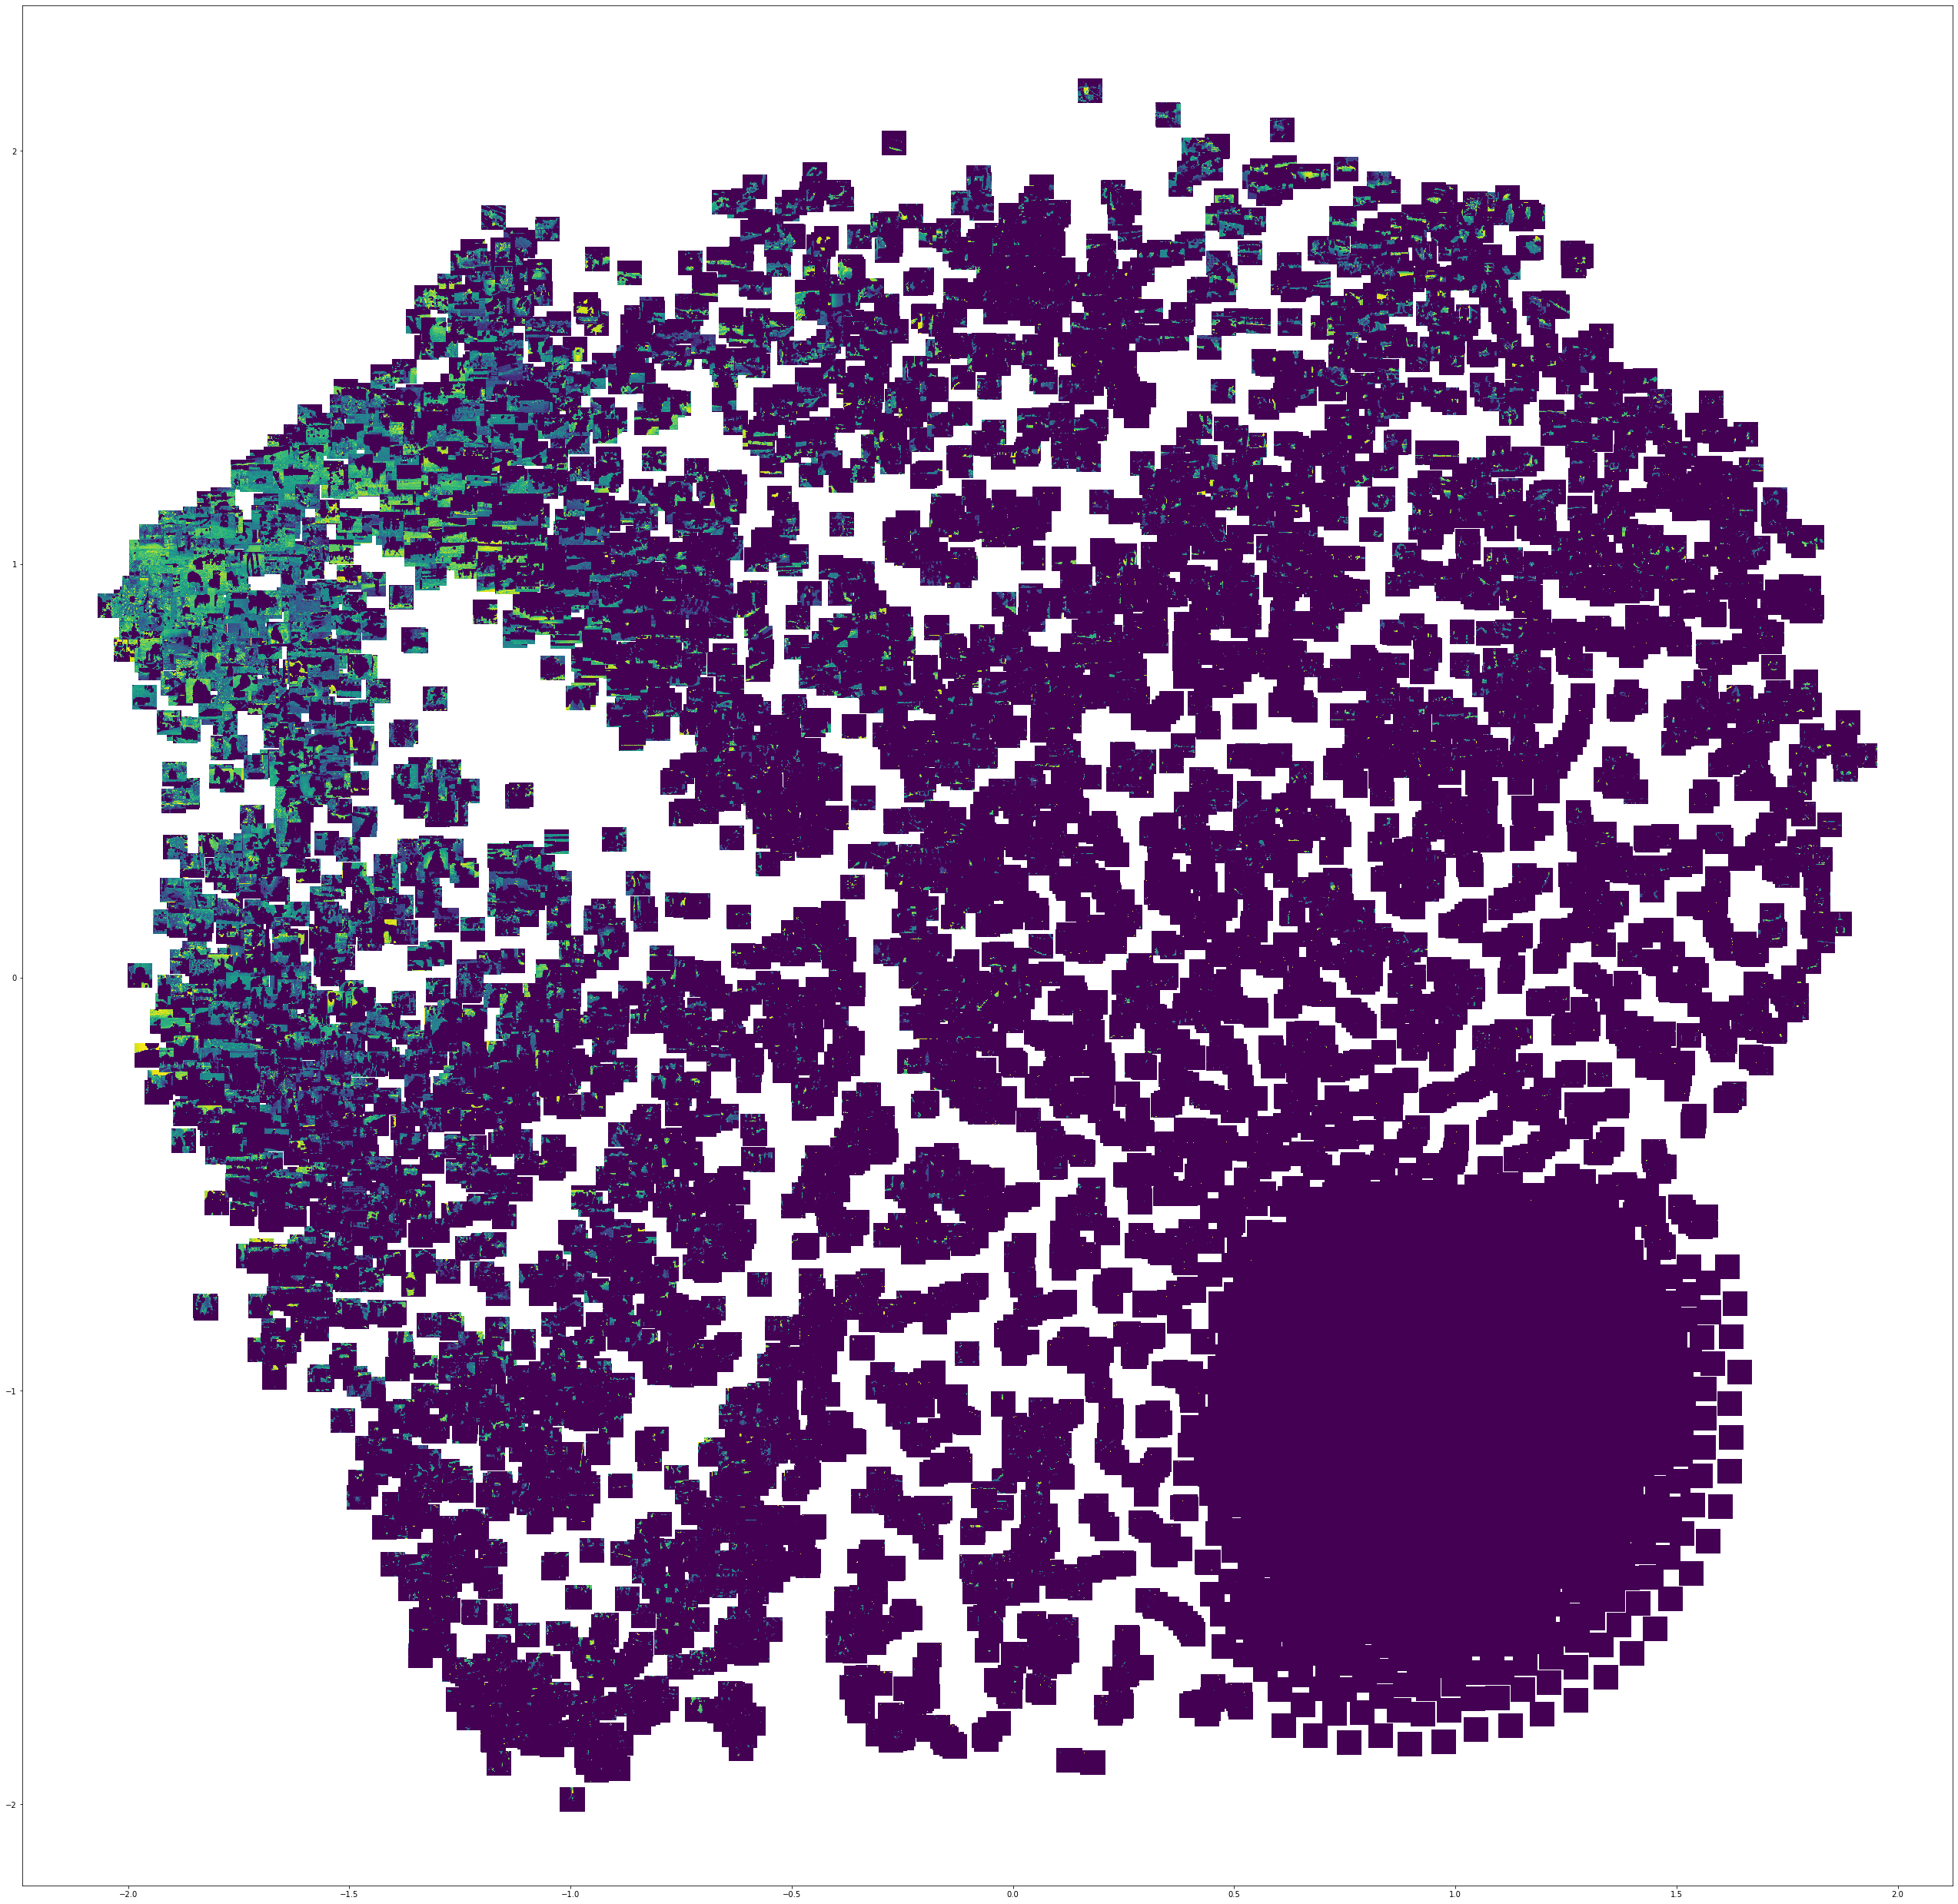

In [32]:
visualize_scatter_with_images(tsne_result_scaled, images = [np.reshape(i, (45,45)) for i in images], image_zoom=0.7)


In [35]:
anim = animation.FuncAnimation(fig, lambda frame_number: ax.view_init(30, 4 * frame_number), interval=75, frames=90)
plot_3d_animation_filename = 'animation.gif'
anim.save(plot_3d_animation_filename, writer='imagemagick')
import io
import base64
from IPython.display import HTML

video = io.open(plot_3d_animation_filename, 'r+b').read()
